<h1>Train Simple Auto Encoder</h1>

<h3>Set up</h3>

In [314]:
!pip install datasets


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [315]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms as T

from datasets import load_dataset

np.random.seed(42)
torch.manual_seed(42)

mydata = load_dataset('valhalla/emoji-dataset')
keywords = ['face','christmas','superhero','supervillian','mage','vampire','monkey','elf','juggling',
            'boy','girl','adult','person','man','woman','male','female','worker','scientist','technologist',
            'singer','artist','pilot','astronaut','firefighter','police','sleuth','construction']

selected_images = []
selected_texts = []

# mydata['train'] ##['image', 'text'], # num_rows : 2749
for i in range(len(mydata['train'])):
    im = mydata['train'][i]['image']
    text = mydata['train'][i]['text'].lower()

    if any(kw in text for kw in keywords):

        im = im.resize((64, 64), Image.LANCZOS)
        arr = np.array(im, dtype=np.float32) / 255.0
        arr = np.transpose(arr, (2, 0, 1))
        selected_images.append(arr)
        selected_texts.append(text)

data = np.stack(selected_images)
x_q2 = torch.from_numpy(data)  # for later use (unshuffled data)


<h3>Conv Autoencoder</h3>

In [316]:
class ConvAutoencoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim = 256):
        super().__init__()
        self.in_channels = in_channels

        # ------------- Encoder -------------
        self.encoder = nn.Sequential(
            # Input: (B, in_channels, 64, 64)
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),  # -> (B, 32, 32, 32)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),           # -> (B, 64, 16, 16)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),          # -> (B, 128, 8, 8)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),         # -> (B, 256, 4, 4)
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.encoder_out_dim = 256 * 4 * 4

        # # Dense bottleneck: 4096 -> 1024 -> latent_dim
        # self.fc_enc = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(self.encoder_out_dim, 1024),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(1024, latent_dim),
        # )

        # # Dense decoder: latent_dim -> 1024 -> 4096
        # self.fc_dec = nn.Sequential(
        #     nn.Linear(latent_dim, 1024),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(1024, self.encoder_out_dim),
        #     nn.ReLU(inplace=True),
        # )
        
        
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(self.encoder_out_dim, latent_dim)
        self.unflatten = nn.Linear(latent_dim, self.encoder_out_dim)

        # ------------- Decoder -------------
        self.decoder = nn.Sequential(
            # Start from (B, 256, 4, 4)
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (B, 128, 8, 8)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   # -> (B, 64, 16, 16)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),    # -> (B, 32, 32, 32)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(32, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),   # -> (B, C, 64, 64)
            nn.Sigmoid() # assuming input images normalized to [0, 1]
        )

    def encode(self, x):
        x = self.encoder(x)            # (B, 256, 4, 4)
        x = self.flatten(x)
        z = self.fc_mu(x)
        return z
    
    def decode(self, z):
        x = self.unflatten(z)             # (B, 256*4*4)
        x = x.view(-1, 256, 4, 4)      # (B, 256, 4, 4)
        x = self.decoder(x)            # (B, C, 64, 64)
        return x
    
    def forward(self, x):
        z = self.encode(x)
        out = self.decode(z)
        return out

<h3>60/20/20 Split</h3>

In [317]:
x = torch.from_numpy(data)

# shuffle
N = x.shape[0]  # number of images
indices = torch.randperm(N)
x = x[indices]

n_train = int(0.6*N)
n_val = int(0.2*N)
n_test = N - n_train - n_val

x_train = x[:n_train]
x_val = x[n_train:n_train+n_val]
x_test = x[n_train+n_val:]

print("Train:", x_train.shape[0], "Val:", x_val.shape[0], "Test:", x_test.shape[0])

Train: 733 Val: 244 Test: 245


<h3>Data Augmentation</h3>

In [318]:
class EmojiDataset(Dataset):
    def __init__(self, data_tensor, transform=None):
        self.data = data_tensor
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        img = self.data[idx]
        if self.transform:
            img = self.transform(img)
        return img
    

train_transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5)
])

train_ds = EmojiDataset(x_train, transform=train_transform)
val_ds = EmojiDataset(x_val, transform=None)
test_ds = EmojiDataset(x_test, transform=None)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

In [319]:
device = torch.device("cpu")
print("Using device:", device)

latent_dim = 1024
lr = 1e-3
model = ConvAutoencoder(in_channels=3, latent_dim=latent_dim).to(device)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Using device: cpu


<h3>Learning Curve</h3>

In [320]:
num_epochs = 100

train_losses = []
val_losses = []

for epoch in range(num_epochs):

    ## train
    model.train()
    running_train = 0.0

    for batch in train_dl:
        images = batch.to(device)
        recon = model(images)
        loss = criterion(recon, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train += loss.item() * images.size(0)

    epoch_train = running_train / len(train_ds)

    ## val
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for batch in val_dl:
            images = batch.to(device)
            recon = model(images)
            loss = criterion(recon, images)
            running_val += loss.item() * images.size(0)
        
    epoch_val = running_val / len(val_ds)

    train_losses.append(epoch_train)
    val_losses.append(epoch_val)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train: {epoch_train:.4f} Val: {epoch_val: .4f}")


Epoch [1/100] Train: 0.2951 Val:  0.2310
Epoch [2/100] Train: 0.2094 Val:  0.1732
Epoch [3/100] Train: 0.1602 Val:  0.1438
Epoch [4/100] Train: 0.1303 Val:  0.1211
Epoch [5/100] Train: 0.1139 Val:  0.1103
Epoch [6/100] Train: 0.1029 Val:  0.1005
Epoch [7/100] Train: 0.0963 Val:  0.0966
Epoch [8/100] Train: 0.0902 Val:  0.0940
Epoch [9/100] Train: 0.0856 Val:  0.0893
Epoch [10/100] Train: 0.0822 Val:  0.0850
Epoch [11/100] Train: 0.0790 Val:  0.0805
Epoch [12/100] Train: 0.0764 Val:  0.0793
Epoch [13/100] Train: 0.0747 Val:  0.0772
Epoch [14/100] Train: 0.0720 Val:  0.0738
Epoch [15/100] Train: 0.0699 Val:  0.0748
Epoch [16/100] Train: 0.0681 Val:  0.0711
Epoch [17/100] Train: 0.0668 Val:  0.0712
Epoch [18/100] Train: 0.0647 Val:  0.0704
Epoch [19/100] Train: 0.0648 Val:  0.0699
Epoch [20/100] Train: 0.0619 Val:  0.0671
Epoch [21/100] Train: 0.0633 Val:  0.0666
Epoch [22/100] Train: 0.0604 Val:  0.0649
Epoch [23/100] Train: 0.0597 Val:  0.0629
Epoch [24/100] Train: 0.0586 Val:  0.0635
E

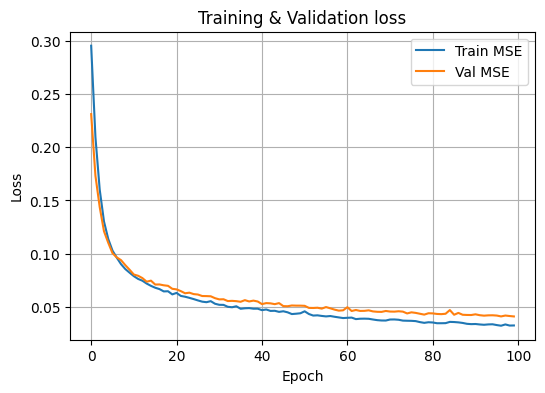

In [321]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train MSE')
plt.plot(val_losses, label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation loss')
plt.legend()
plt.grid(True)
plt.show()

In [322]:
model.eval()
test_running = 0.0
with torch.no_grad():
    for batch in test_dl:
        images = batch.to(device)
        recon = model(images)
        loss = criterion(recon, images)
        test_running += loss.item() * images.size(0)

test_mse = test_running / len(test_ds)
print("Final average test error:", test_mse)

Final average test error: 0.040810961565192864


<h3>5 side by side input and output images</h3>

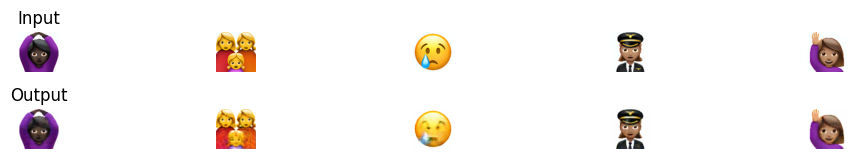

In [323]:
model.eval()

# small batch from the test set
test_batch = next(iter(test_dl))
test_batch = test_batch.to(device)
with torch.no_grad():
    out_batch = model(test_batch)

test_batch_np = test_batch.cpu().numpy()
out_batch_np = out_batch.cpu().numpy()

num_examples = 5
plt.figure(figsize=(10,4))

for i in range(num_examples):
    # input
    plt.subplot(5, num_examples, i+1)
    img = np.transpose(test_batch_np[i], (1, 2, 0))
    plt.imshow(img)
    plt.axis('off')
    if i == 0:
        plt.title("Input")

    # Output
    plt.subplot(5, num_examples, num_examples + i+1)
    img = np.transpose(out_batch_np[i], (1, 2, 0))
    plt.imshow(img)
    plt.axis('off')
    if i == 0:
        plt.title("Output")

plt.tight_layout()
plt.show()

<h2>Adding Features</h2>

In [324]:
def find_indices_with(substring):
    substring = substring.lower()
    return [i for i, txt in enumerate(selected_texts) if substring in txt]

print("Examples of 'face'", find_indices_with("face"))
print("Examples of 'nerd'", find_indices_with("nerd"))
print("Examples of 'smiling face'", find_indices_with("smiling face"))

Examples of 'face' [0, 1, 2, 3, 14, 25, 35, 41, 52, 63, 69, 79, 90, 101, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 188, 262, 334, 414, 465, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 488, 489, 494, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 529, 530, 535, 540, 541, 543, 544, 548, 552, 553, 554, 561, 562, 564, 570, 574, 578, 579, 580, 581, 582, 591, 602, 603, 614, 625, 636, 647, 658, 669, 680, 691, 702, 713, 714, 725, 736, 737, 738, 739, 740, 741, 742, 747, 756, 757, 758, 759, 760, 761, 762, 769, 776, 777, 778, 779, 780, 781, 782, 791, 802, 813, 824, 835, 846, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 884, 895, 906, 917, 928, 929, 940, 951, 962, 973, 984, 995, 1006, 1017, 1028, 1039, 1040, 1051, 1062, 1073, 1084, 109

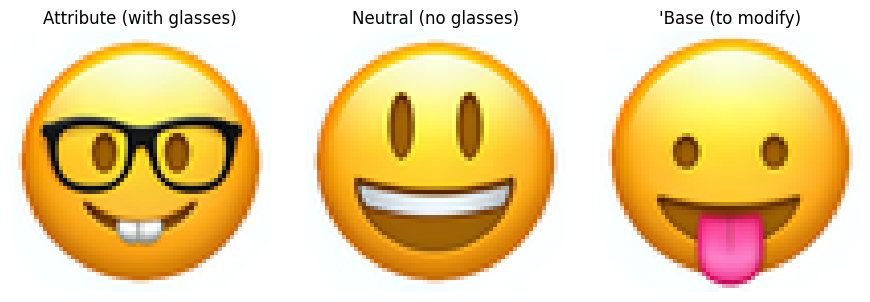

In [325]:
idx_attr = int(find_indices_with("nerd face")[0])
idx_neutral = int(find_indices_with("smiling face")[0])
idx_base = 540

plt.figure(figsize=(9,3))
for i, idx in enumerate([idx_attr, idx_neutral, idx_base]):
    plt.subplot(1, 3, i+1)
    plt.imshow(np.transpose(x_q2[idx].numpy(), (1, 2, 0)))
    plt.axis('off')
    if i == 0:
        plt.title("Attribute (with glasses)")
    elif i == 1:
        plt.title("Neutral (no glasses)")
    else: plt.title("'Base (to modify)")

plt.tight_layout()
plt.show()

<h3>Image Generation</h3>

In [326]:
upper_bound = 15
lower_bound = 512
alpha = 1.0

model.eval()

with torch.no_grad():
    img_attr = x_q2[idx_attr].unsqueeze(0).to(device)
    img_neutral = x_q2[idx_neutral].unsqueeze(0).to(device)
    img_base = x_q2[idx_base].unsqueeze(0).to(device)

    z_attr = model.encode(img_attr)
    z_neutral = model.encode(img_neutral)
    # z_neutral_mu = z_neutral.mean(dim=0, keepdim=True)
    z_base = model.encode(img_base)

    # attr_vector = z_attr - z_neutral
    # flat_attr = attr_vector.flatten()
    # upper = torch.zeros_like(flat_attr, dtype=torch.bool)
    # upper[torch.topk(torch.abs(flat_attr), upper_bound).indices] = True

    # lower = torch.zeros_like(flat_attr, dtype=torch.bool)
    # lower[torch.topk(torch.abs(flat_attr), lower_bound).indices] = True

    # mask = lower & ~upper
    # flat_attr[~mask] = 0
    # attr_vector = flat_attr.reshape(attr_vector.shape)

    attr_vector = z_attr - z_neutral

    
    z_new = z_base + alpha * attr_vector
    
    gen_img = model.decode(z_new)


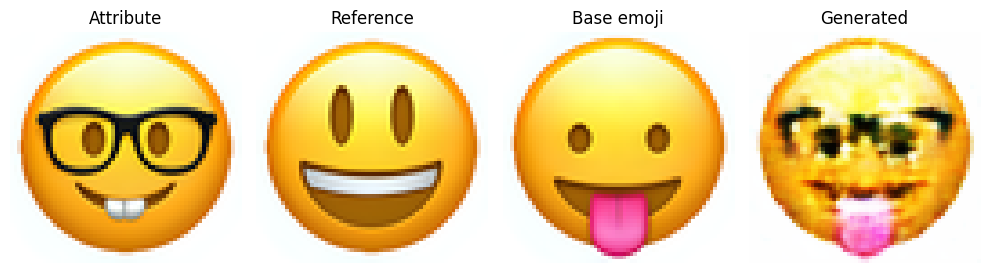

In [352]:
def tensor_to_img(t):
    if t.dim() == 4:
        t = t[0]

    img = t.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1)
    return img

img_attr_np = tensor_to_img(img_attr)
img_neutral_np = tensor_to_img(img_neutral)
img_base_np = tensor_to_img(img_base)
gen_img_np = tensor_to_img(gen_img)

plt.figure(figsize=(10, 3))

plt.subplot(1, 4, 1)
plt.imshow(img_attr_np)
plt.axis('off')
plt.title("Attribute")

plt.subplot(1, 4, 2)
plt.imshow(img_neutral_np)
plt.axis('off')
plt.title("Reference")

plt.subplot(1, 4, 3)
plt.imshow(img_base_np)
plt.axis('off')
plt.title("Base emoji")

plt.subplot(1, 4, 4)
plt.imshow(gen_img_np)
plt.axis('off')
plt.title("Generated")

plt.tight_layout()
plt.show()

<h3>Test if masking helps, turns out it didn't really help</h3>

<h4>Also tried taking average of neutral attributes but this was also not very helpful</h4>

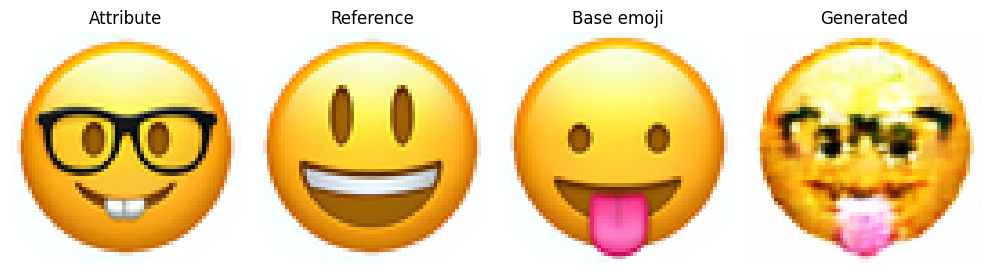

In [353]:
idx_attr = int(find_indices_with("nerd face")[0])
idx_neutral = int(find_indices_with("smiling face")[0])
idx_base = 540

upper_bound = 15
lower_bound = 512
alpha = 1.2

model.eval()

with torch.no_grad():
    img_attr = x_q2[idx_attr].unsqueeze(0).to(device)
    img_neutral = x_q2[idx_neutral].unsqueeze(0).to(device)
    img_base = x_q2[idx_base].unsqueeze(0).to(device)

    z_attr = model.encode(img_attr)
    z_neutral = model.encode(img_neutral)
    z_base = model.encode(img_base)

    attr_vector = z_attr - z_neutral
    flat_attr = attr_vector.flatten()
    upper = torch.zeros_like(flat_attr, dtype=torch.bool)
    upper[torch.topk(torch.abs(flat_attr), upper_bound).indices] = True

    lower = torch.zeros_like(flat_attr, dtype=torch.bool)
    lower[torch.topk(torch.abs(flat_attr), lower_bound).indices] = True

    mask = lower & ~upper
    flat_attr[~mask] = 0
    attr_vector = flat_attr.reshape(attr_vector.shape)

    # attr_vector = z_attr - z_neutral_mu
    z_new = z_base + alpha * attr_vector
    
    gen_img = model.decode(z_new)



def tensor_to_img(t):
    if t.dim() == 4:
        t = t[0]

    img = t.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    # img = np.clip(img, 0, 1)
    return img

img_attr_np = tensor_to_img(img_attr)
img_neutral_np = tensor_to_img(img_neutral)
img_base_np = tensor_to_img(img_base)
gen_img_np = tensor_to_img(gen_img)

plt.figure(figsize=(10, 3))

plt.subplot(1, 4, 1)
plt.imshow(img_attr_np)
plt.axis('off')
plt.title("Attribute")

plt.subplot(1, 4, 2)
plt.imshow(img_neutral_np)
plt.axis('off')
plt.title("Reference")

plt.subplot(1, 4, 3)
plt.imshow(img_base_np)
plt.axis('off')
plt.title("Base emoji")

plt.subplot(1, 4, 4)
plt.imshow(gen_img_np)
plt.axis('off')
plt.title("Generated")

plt.tight_layout()
plt.show()

<h2>Experimenting and saving models</h2>

<h4>Tried several times and tested -> got different results due to randomness, so saved models that had good results </h4>
<h4>Also trained with 200 epochs</h4>

Train: 733 Val: 244 Test: 245
Using device: cpu


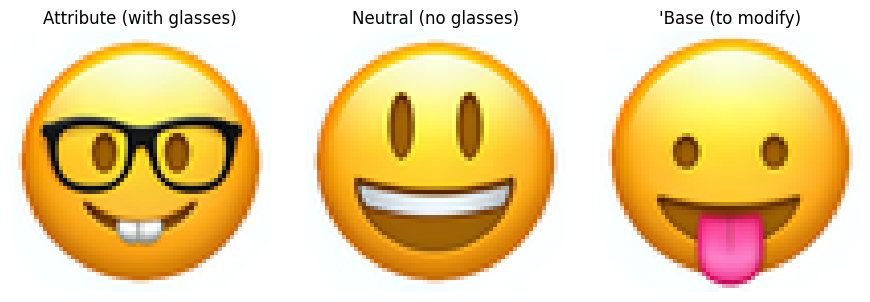

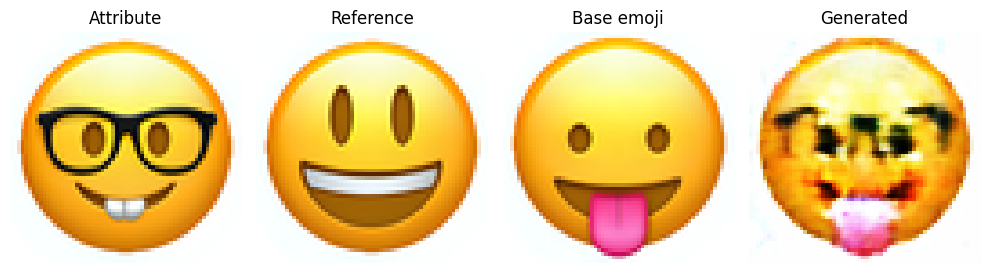

In [356]:
class ConvAutoencoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim = 256):
        super().__init__()
        self.in_channels = in_channels

        # ------------- Encoder -------------
        self.encoder = nn.Sequential(
            # Input: (B, in_channels, 64, 64)
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),  # -> (B, 32, 32, 32)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),           # -> (B, 64, 16, 16)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),          # -> (B, 128, 8, 8)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),         # -> (B, 256, 4, 4)
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.encoder_out_dim = 256 * 4 * 4

        # # Dense bottleneck: 4096 -> 1024 -> latent_dim
        # self.fc_enc = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(self.encoder_out_dim, 1024),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(1024, latent_dim),
        # )

        # # Dense decoder: latent_dim -> 1024 -> 4096
        # self.fc_dec = nn.Sequential(
        #     nn.Linear(latent_dim, 1024),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(1024, self.encoder_out_dim),
        #     nn.ReLU(inplace=True),
        # )
        
        
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(self.encoder_out_dim, latent_dim)
        self.unflatten = nn.Linear(latent_dim, self.encoder_out_dim)

        # ------------- Decoder -------------
        self.decoder = nn.Sequential(
            # Start from (B, 256, 4, 4)
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (B, 128, 8, 8)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   # -> (B, 64, 16, 16)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),    # -> (B, 32, 32, 32)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(32, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),   # -> (B, C, 64, 64)
            nn.Sigmoid() # assuming input images normalized to [0, 1]
        )

    def encode(self, x):
        x = self.encoder(x)            # (B, 256, 4, 4)
        x = self.flatten(x)
        z = self.fc_mu(x)
        return z
    
    def decode(self, z):
        x = self.unflatten(z)             # (B, 256*4*4)
        x = x.view(-1, 256, 4, 4)      # (B, 256, 4, 4)
        x = self.decoder(x)            # (B, C, 64, 64)
        return x
    
    def forward(self, x):
        z = self.encode(x)
        out = self.decode(z)
        return out


x = torch.from_numpy(data)

# shuffle
N = x.shape[0]  # number of images
indices = torch.randperm(N)
x = x[indices]

n_train = int(0.6*N)
n_val = int(0.2*N)
n_test = N - n_train - n_val

x_train = x[:n_train]
x_val = x[n_train:n_train+n_val]
x_test = x[n_train+n_val:]

print("Train:", x_train.shape[0], "Val:", x_val.shape[0], "Test:", x_test.shape[0])


class EmojiDataset(Dataset):
    def __init__(self, data_tensor, transform=None):
        self.data = data_tensor
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        img = self.data[idx]
        if self.transform:
            img = self.transform(img)
        return img
    

train_transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5)
])

train_ds = EmojiDataset(x_train, transform=train_transform)
val_ds = EmojiDataset(x_val, transform=None)
test_ds = EmojiDataset(x_test, transform=None)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

device = torch.device("cpu")
print("Using device:", device)

latent_dim = 1024
lr = 1e-3
model = ConvAutoencoder(in_channels=3, latent_dim=latent_dim).to(device)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


num_epochs = 200

train_losses = []
val_losses = []

for epoch in range(num_epochs):

    ## train
    model.train()
    running_train = 0.0

    for batch in train_dl:
        images = batch.to(device)
        recon = model(images)
        loss = criterion(recon, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train += loss.item() * images.size(0)

    epoch_train = running_train / len(train_ds)

    ## val
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for batch in val_dl:
            images = batch.to(device)
            recon = model(images)
            loss = criterion(recon, images)
            running_val += loss.item() * images.size(0)
        
    epoch_val = running_val / len(val_ds)

    train_losses.append(epoch_train)
    val_losses.append(epoch_val)


def find_indices_with(substring):
    substring = substring.lower()
    return [i for i, txt in enumerate(selected_texts) if substring in txt]



idx_attr = int(find_indices_with("nerd face")[0])
idx_neutral = int(find_indices_with("smiling face")[0])
idx_base = 540

plt.figure(figsize=(9,3))
for i, idx in enumerate([idx_attr, idx_neutral, idx_base]):
    plt.subplot(1, 3, i+1)
    plt.imshow(np.transpose(x_q2[idx].numpy(), (1, 2, 0)))
    plt.axis('off')
    if i == 0:
        plt.title("Attribute (with glasses)")
    elif i == 1:
        plt.title("Neutral (no glasses)")
    else:
        plt.title("'Base (to modify)")

plt.tight_layout()
plt.show()


upper_bound = 15
lower_bound = 512
alpha = 1.0

model.eval()

with torch.no_grad():
    img_attr = x_q2[idx_attr].unsqueeze(0).to(device)
    img_neutral = x_q2[idx_neutral].unsqueeze(0).to(device)
    img_base = x_q2[idx_base].unsqueeze(0).to(device)

    z_attr = model.encode(img_attr)
    z_neutral = model.encode(img_neutral)
    z_base = model.encode(img_base)


    attr_vector = z_attr - z_neutral
    z_new = z_base + alpha * attr_vector
    
    gen_img = model.decode(z_new)


def tensor_to_img(t):
    if t.dim() == 4:
        t = t[0]

    img = t.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    # img = np.clip(img, 0, 1)
    return img


img_attr_np = tensor_to_img(img_attr)
img_neutral_np = tensor_to_img(img_neutral)
img_base_np = tensor_to_img(img_base)
gen_img_np = tensor_to_img(gen_img)

plt.figure(figsize=(10, 3))

plt.subplot(1, 4, 1)
plt.imshow(img_attr_np)
plt.axis('off')
plt.title("Attribute")

plt.subplot(1, 4, 2)
plt.imshow(img_neutral_np)
plt.axis('off')
plt.title("Reference")

plt.subplot(1, 4, 3)
plt.imshow(img_base_np)
plt.axis('off')
plt.title("Base emoji")

plt.subplot(1, 4, 4)
plt.imshow(gen_img_np)
plt.axis('off')
plt.title("Generated")

plt.tight_layout()
plt.show()


In [333]:
torch.save(model.state_dict(), "emoji_autoencoder_good.pth")
print("Model saved!")

Model saved!


In [344]:
torch.save(model.state_dict(), "emoji_autoencoder_glasses_clear.pth")
print("Model saved!")

Model saved!


In [350]:
torch.save(model.state_dict(), "emoji_autoencoder_200.pth")
print("Model saved!")

Model saved!


<h2>Used saved models to generate emojis</h2>

<h4>1. emoji_autoencoder_good</h4>
<h4>2. emoji_autoencoder_glasses</h4>
<h4>3. emoji_autoencoder_200</h4>

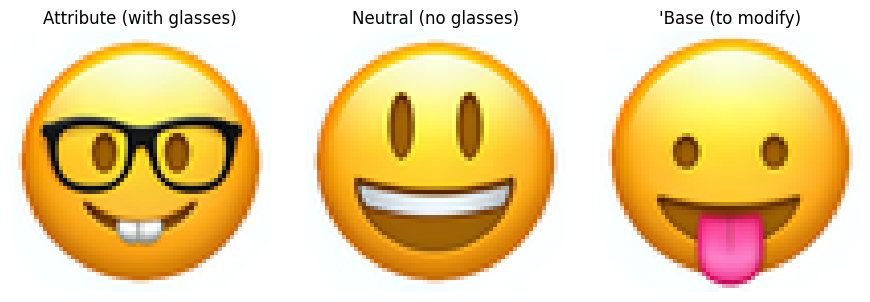

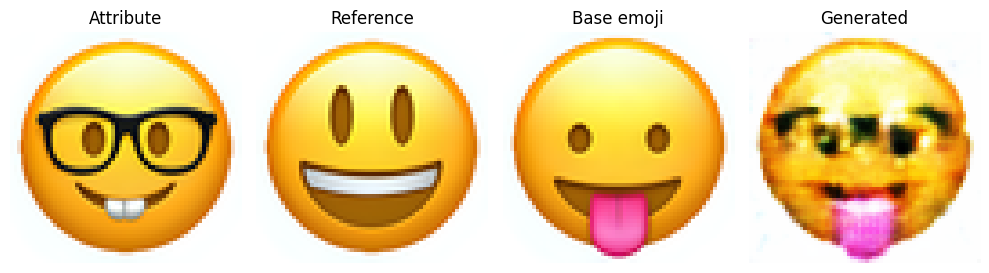

In [357]:
###### emoji_autoencoder_good ######

model = ConvAutoencoder(in_channels=3, latent_dim=latent_dim).to(device)
model.load_state_dict(torch.load("emoji_autoencoder_good.pth", map_location=device))
model.eval()

def find_indices_with(substring):
    substring = substring.lower()
    return [i for i, txt in enumerate(selected_texts) if substring in txt]



idx_attr = int(find_indices_with("nerd face")[0])
idx_neutral = int(find_indices_with("smiling face")[0])
idx_base = 540

plt.figure(figsize=(9,3))
for i, idx in enumerate([idx_attr, idx_neutral, idx_base]):
    plt.subplot(1, 3, i+1)
    plt.imshow(np.transpose(x_q2[idx].numpy(), (1, 2, 0)))
    plt.axis('off')
    if i == 0:
        plt.title("Attribute (with glasses)")
    elif i == 1:
        plt.title("Neutral (no glasses)")
    else:
        plt.title("'Base (to modify)")

plt.tight_layout()
plt.show()

upper_bound = 15
lower_bound = 512
alpha = 1.0

model.eval()

with torch.no_grad():
    img_attr = x_q2[idx_attr].unsqueeze(0).to(device)
    img_neutral = x_q2[idx_neutral].unsqueeze(0).to(device)
    img_base = x_q2[idx_base].unsqueeze(0).to(device)

    z_attr = model.encode(img_attr)
    z_neutral = model.encode(img_neutral)
    z_base = model.encode(img_base)


    attr_vector = z_attr - z_neutral
    z_new = z_base + alpha * attr_vector
    
    gen_img = model.decode(z_new)


def tensor_to_img(t):
    if t.dim() == 4:
        t = t[0]

    img = t.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    # img = np.clip(img, 0, 1)
    return img


img_attr_np = tensor_to_img(img_attr)
img_neutral_np = tensor_to_img(img_neutral)
img_base_np = tensor_to_img(img_base)
gen_img_np = tensor_to_img(gen_img)

plt.figure(figsize=(10, 3))

plt.subplot(1, 4, 1)
plt.imshow(img_attr_np)
plt.axis('off')
plt.title("Attribute")

plt.subplot(1, 4, 2)
plt.imshow(img_neutral_np)
plt.axis('off')
plt.title("Reference")

plt.subplot(1, 4, 3)
plt.imshow(img_base_np)
plt.axis('off')
plt.title("Base emoji")

plt.subplot(1, 4, 4)
plt.imshow(gen_img_np)
plt.axis('off')
plt.title("Generated")

plt.tight_layout()
plt.show()


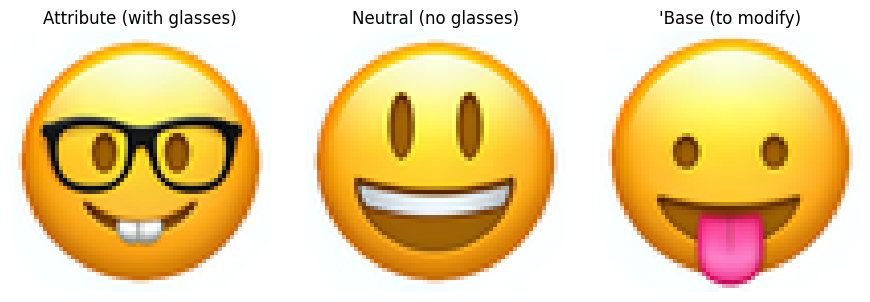

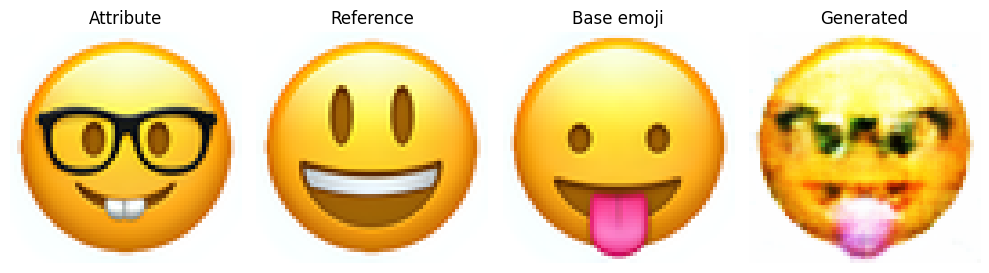

In [358]:
###### emoji_autoencoder_glasses ######

model = ConvAutoencoder(in_channels=3, latent_dim=latent_dim).to(device)
model.load_state_dict(torch.load("emoji_autoencoder_glasses_clear.pth", map_location=device))
model.eval()

def find_indices_with(substring):
    substring = substring.lower()
    return [i for i, txt in enumerate(selected_texts) if substring in txt]



idx_attr = int(find_indices_with("nerd face")[0])
idx_neutral = int(find_indices_with("smiling face")[0])
idx_base = 540

plt.figure(figsize=(9,3))
for i, idx in enumerate([idx_attr, idx_neutral, idx_base]):
    plt.subplot(1, 3, i+1)
    plt.imshow(np.transpose(x_q2[idx].numpy(), (1, 2, 0)))
    plt.axis('off')
    if i == 0:
        plt.title("Attribute (with glasses)")
    elif i == 1:
        plt.title("Neutral (no glasses)")
    else:
        plt.title("'Base (to modify)")

plt.tight_layout()
plt.show()

upper_bound = 15
lower_bound = 512
alpha = 1.0

model.eval()

with torch.no_grad():
    img_attr = x_q2[idx_attr].unsqueeze(0).to(device)
    img_neutral = x_q2[idx_neutral].unsqueeze(0).to(device)
    img_base = x_q2[idx_base].unsqueeze(0).to(device)

    z_attr = model.encode(img_attr)
    z_neutral = model.encode(img_neutral)
    z_base = model.encode(img_base)


    attr_vector = z_attr - z_neutral
    z_new = z_base + alpha * attr_vector
    
    gen_img = model.decode(z_new)


def tensor_to_img(t):
    if t.dim() == 4:
        t = t[0]

    img = t.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    # img = np.clip(img, 0, 1)
    return img


img_attr_np = tensor_to_img(img_attr)
img_neutral_np = tensor_to_img(img_neutral)
img_base_np = tensor_to_img(img_base)
gen_img_np = tensor_to_img(gen_img)

plt.figure(figsize=(10, 3))

plt.subplot(1, 4, 1)
plt.imshow(img_attr_np)
plt.axis('off')
plt.title("Attribute")

plt.subplot(1, 4, 2)
plt.imshow(img_neutral_np)
plt.axis('off')
plt.title("Reference")

plt.subplot(1, 4, 3)
plt.imshow(img_base_np)
plt.axis('off')
plt.title("Base emoji")

plt.subplot(1, 4, 4)
plt.imshow(gen_img_np)
plt.axis('off')
plt.title("Generated")

plt.tight_layout()
plt.show()


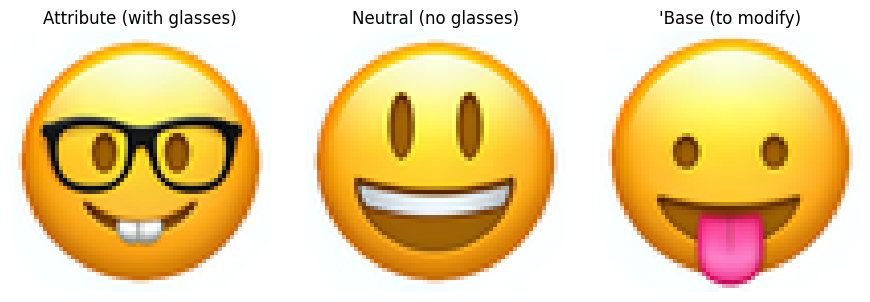

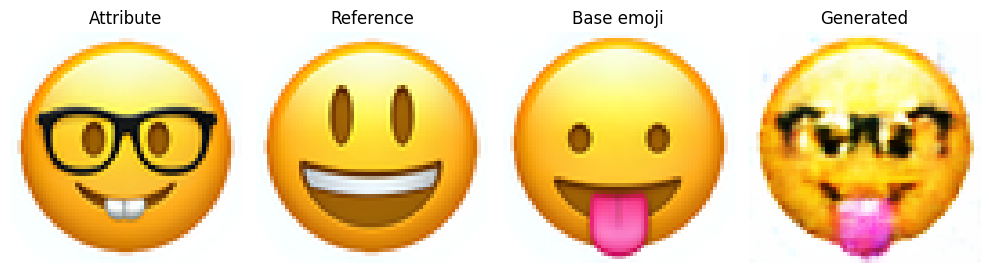

In [359]:
###### emoji_autoencoder_200 ######

model = ConvAutoencoder(in_channels=3, latent_dim=latent_dim).to(device)
model.load_state_dict(torch.load("emoji_autoencoder_200.pth", map_location=device))
model.eval()

def find_indices_with(substring):
    substring = substring.lower()
    return [i for i, txt in enumerate(selected_texts) if substring in txt]



idx_attr = int(find_indices_with("nerd face")[0])
idx_neutral = int(find_indices_with("smiling face")[0])
idx_base = 540

plt.figure(figsize=(9,3))
for i, idx in enumerate([idx_attr, idx_neutral, idx_base]):
    plt.subplot(1, 3, i+1)
    plt.imshow(np.transpose(x_q2[idx].numpy(), (1, 2, 0)))
    plt.axis('off')
    if i == 0:
        plt.title("Attribute (with glasses)")
    elif i == 1:
        plt.title("Neutral (no glasses)")
    else:
        plt.title("'Base (to modify)")

plt.tight_layout()
plt.show()

upper_bound = 15
lower_bound = 512
alpha = 1.0

model.eval()

with torch.no_grad():
    img_attr = x_q2[idx_attr].unsqueeze(0).to(device)
    img_neutral = x_q2[idx_neutral].unsqueeze(0).to(device)
    img_base = x_q2[idx_base].unsqueeze(0).to(device)

    z_attr = model.encode(img_attr)
    z_neutral = model.encode(img_neutral)
    z_base = model.encode(img_base)


    attr_vector = z_attr - z_neutral
    z_new = z_base + alpha * attr_vector
    
    gen_img = model.decode(z_new)


def tensor_to_img(t):
    if t.dim() == 4:
        t = t[0]

    img = t.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    # img = np.clip(img, 0, 1)
    return img


img_attr_np = tensor_to_img(img_attr)
img_neutral_np = tensor_to_img(img_neutral)
img_base_np = tensor_to_img(img_base)
gen_img_np = tensor_to_img(gen_img)

plt.figure(figsize=(10, 3))

plt.subplot(1, 4, 1)
plt.imshow(img_attr_np)
plt.axis('off')
plt.title("Attribute")

plt.subplot(1, 4, 2)
plt.imshow(img_neutral_np)
plt.axis('off')
plt.title("Reference")

plt.subplot(1, 4, 3)
plt.imshow(img_base_np)
plt.axis('off')
plt.title("Base emoji")

plt.subplot(1, 4, 4)
plt.imshow(gen_img_np)
plt.axis('off')
plt.title("Generated")

plt.tight_layout()
plt.show()
